In [ ]:
!pip install -q kagglehub


In [ ]:
import tensorflow as tf
import os
import json
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


In [ ]:
import kagglehub

DATASET_PATH = kagglehub.dataset_download(
    "vipoooool/new-plant-diseases-dataset"
)

print("Dataset path:", DATASET_PATH)


Using Colab cache for faster access to the 'new-plant-diseases-dataset' dataset.
Dataset path: /kaggle/input/new-plant-diseases-dataset


In [ ]:
os.listdir(DATASET_PATH)


['New Plant Diseases Dataset(Augmented)',
 'new plant diseases dataset(augmented)',
 'test']

In [ ]:
BASE_DIR = os.path.join(
    DATASET_PATH,
    "New Plant Diseases Dataset(Augmented)",
    "New Plant Diseases Dataset(Augmented)"
)

os.listdir(BASE_DIR)


['valid', 'train']

In [ ]:
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "valid")


In [ ]:
print("Train:", os.path.exists(TRAIN_DIR))
print("Valid:", os.path.exists(VAL_DIR))


Train: True
Valid: True


In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


In [ ]:
train_data = train_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_data = val_gen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)


Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [ ]:
base_model = EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)

x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)

outputs = Dense(train_data.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,415,305 (16.84 MB)

 Trainable params: 365,734 (1.40 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1309s 583ms/step - accuracy: 0.3365 - loss: 2.5064 - val_accuracy: 0.8857 - val_loss: 0.4591
Epoch 2/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 875s 398ms/step - accuracy: 0.7670 - loss: 0.7628 - val_accuracy: 0.9215 - val_loss: 0.2717
Epoch 3/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 896s 408ms/step - accuracy: 0.8425 - loss: 0.5100 - val_accuracy: 0.9397 - val_loss: 0.2024
Epoch 4/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 904s 412ms/step - accuracy: 0.8747 - loss: 0.4007 - val_accuracy: 0.9475 - val_loss: 0.1704
Epoch 5/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 914s 416ms/step - accuracy: 0.8945 - loss: 0.3371 - val_accuracy: 0.9531 - val_loss: 0.1480


In [ ]:
model.save("plant_disease_efficientnetb0.h5")

with open("class_labels.json", "w") as f:
    json.dump(train_data.class_indices, f)


In [ ]:
from google.colab import files

files.download("plant_disease_efficientnetb0.h5")
files.download("class_labels.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_dir = os.path.join(DATASET_PATH, "test")

test_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=1,
    class_mode="categorical",
    shuffle=False
)


Found 33 images belonging to 1 classes.


In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print("Test Accuracy:", test_acc)


33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.1630 - loss: 484.6257
Test Accuracy: 0.09090909361839294


In [ ]:
import random

img_path = random.choice(test_data.filepaths)
print("Testing image:", img_path)


Testing image: /kaggle/input/new-plant-diseases-dataset/test/test/TomatoEarlyBlight6.JPG


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Predicted class: Tomato___Early_blight
Confidence: 90.53%


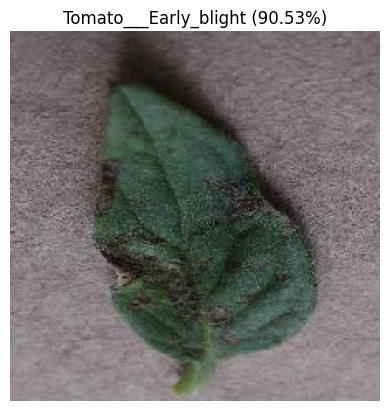

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

img_path = "/kaggle/input/new-plant-diseases-dataset/test/test/TomatoEarlyBlight6.JPG"

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

pred = model.predict(img_array)

class_labels = {v: k for k, v in train_data.class_indices.items()}
predicted_class = class_labels[np.argmax(pred)]
confidence = np.max(pred) * 100

print("Predicted class:", predicted_class)
print(f"Confidence: {confidence:.2f}%")

plt.imshow(img)
plt.axis("off")
plt.title(f"{predicted_class} ({confidence:.2f}%)")
plt.show()


In [ ]:
from google.colab import files

uploaded = files.upload()


Saving example1.jpeg to example1.jpeg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted: Tomato___Early_blight
Confidence: 54.44%


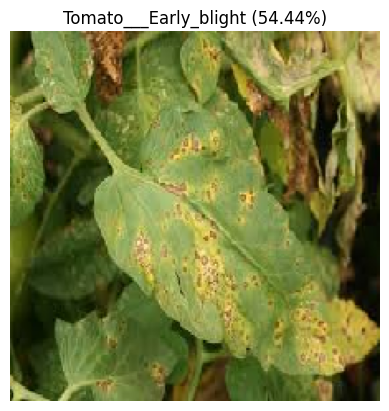

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# get uploaded file name
img_path = list(uploaded.keys())[0]

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

pred = model.predict(img_array)

class_labels = {v: k for k, v in train_data.class_indices.items()}
predicted_class = class_labels[np.argmax(pred)]
confidence = np.max(pred) * 100

print("Predicted:", predicted_class)
print(f"Confidence: {confidence:.2f}%")

plt.imshow(img)
plt.axis("off")
plt.title(f"{predicted_class} ({confidence:.2f}%)")
plt.show()


In [ ]:
from google.colab import files

uploaded = files.upload()


Saving example2.jpg to example2.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted: Tomato___Late_blight
Confidence: 72.33%


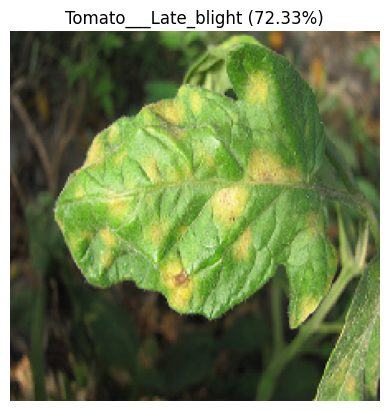

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# get uploaded file name
img_path = list(uploaded.keys())[0]

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

pred = model.predict(img_array)

class_labels = {v: k for k, v in train_data.class_indices.items()}
predicted_class = class_labels[np.argmax(pred)]
confidence = np.max(pred) * 100

print("Predicted:", predicted_class)
print(f"Confidence: {confidence:.2f}%")

plt.imshow(img)
plt.axis("off")
plt.title(f"{predicted_class} ({confidence:.2f}%)")
plt.show()


In [ ]:
class_names = list(train_data.class_indices.keys())

print("Number of classes:", len(class_names))
print("\nClass names:")
for name in class_names:
    print(name)


Number of classes: 38

Class names:
Apple___Apple_scab
Apple___Black_rot
Apple___Cedar_apple_rust
Apple___healthy
Blueberry___healthy
Cherry_(including_sour)___Powdery_mildew
Cherry_(including_sour)___healthy
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
Corn_(maize)___Common_rust_
Corn_(maize)___Northern_Leaf_Blight
Corn_(maize)___healthy
Grape___Black_rot
Grape___Esca_(Black_Measles)
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Grape___healthy
Orange___Haunglongbing_(Citrus_greening)
Peach___Bacterial_spot
Peach___healthy
Pepper,_bell___Bacterial_spot
Pepper,_bell___healthy
Potato___Early_blight
Potato___Late_blight
Potato___healthy
Raspberry___healthy
Soybean___healthy
Squash___Powdery_mildew
Strawberry___Leaf_scorch
Strawberry___healthy
Tomato___Bacterial_spot
Tomato___Early_blight
Tomato___Late_blight
Tomato___Leaf_Mold
Tomato___Septoria_leaf_spot
Tomato___Spider_mites Two-spotted_spider_mite
Tomato___Target_Spot
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Tomato_mosaic_vir